# Diversity Test

This notebook compares categorical index diversity in the ranked recommendations. If you want to see distance comparisons, head out to the next note. 

Number of sampled actions: 50

``` ddpg_action = ddpg_action[np.random.randint(0, 5000, 50)].detach().cpu().numpy() <- that 50 ```

K parameter for TopK ranking: 20 (changed in the query function arguments)

Next part contains A LOT of various graphs that are not grouped. If you want GROUPED comparison, go to the bottom section

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy.spatial import distance
import pickle
import json
import h5py
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='grade3')

def load_file(path, name):
    import importlib.util
    spec = importlib.util.spec_from_file_location(name, path)
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    return mod

models = load_file("../../utils/models.py", "models")


cuda = torch.device('cuda')
frame_size = 10
# https://drive.google.com/open?id=1kTyu05ZmtP2MA33J5hWdX8OyUYEDW4iI
movie_ref = pickle.load(open('../../data/infos_pca128.pytorch', 'rb'))
# on my system os error often pops up
# try to open the file explorer and copy paste the path again 
# https://drive.google.com/open?id=1pPf-7AmUVceVfgfmKEJ6ireEDKEJHw-7
f = h5py.File("../../data/static_ml20m.hdf5", "r")
# https://drive.google.com/open?id=1xjVI4uVQGsQ7tjOJ3594ZXmAEC_6yX0e
meta = json.load(open('../../data/metadata.json'))

In [3]:
ddpg = models.Actor(1290, 128, 256).to(cuda)
td3 = models.Actor(1290, 128, 256).to(cuda)
ddpg.load_state_dict(torch.load('../../models/DDPG/ddpg_policy.pt'))
td3.load_state_dict(torch.load('../../models/TD3/td3_policy_1.pt'))

batch_size = 5000
n_batches = (f['done'].shape[0] // batch_size) - 1

In [4]:
test_batch = [f[key][n_batches*batch_size:(n_batches+1)*batch_size] for key in
                 ['movies', 'ratings', 'done']]


movies, ratings, done = test_batch
movies, ratings, done = [torch.tensor(i.astype('float32')) for i in [movies, ratings, done]]
movies_tensor = torch.stack([torch.stack([movie_ref[int(i)] for i in ts]) for ts in movies])
    
state = torch.cat([movies_tensor[:, :-1, :].view(batch_size, -1),
                       ratings[:, :-1]], 1).to(cuda)

In [5]:
def rank(gen_action, metric):
    scores = []
    for i in movie_ref.keys():
        scores.append([i, metric(movie_ref[i], gen_action)])
    scores = list(sorted(scores, key = lambda x: x[1]))
    scores = scores[:10]
    ids = [i[0] for i in scores]
    dist = [i[1] for i in scores]

    return ids, dist

# Faiss indexing

In [6]:
import faiss
# test indexes
indexL2 = faiss.IndexFlatL2(128)
indexIP = faiss.IndexFlatIP(128)


mov_mat  = np.stack(movie_ref.values()).astype('float32')
indexL2.add(mov_mat)
indexIP.add(mov_mat)

def query(index, action, k=20):
    D, I = index.search(action, k)
    return D, I

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  import sys


# DDPG

In [7]:
ddpg_action = ddpg(state)
ddpg_action = ddpg_action[np.random.randint(0, 5000, 50)].detach().cpu().numpy() 

## L2: number the movie was recommended

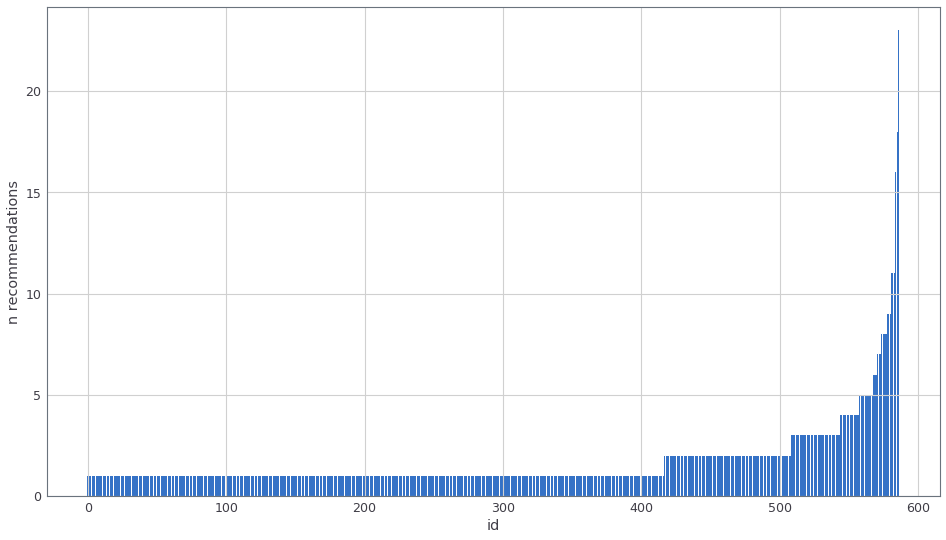

In [8]:
%matplotlib inline

D, I = query(indexL2, ddpg_action)
uniques, counts = np.unique(I, return_counts=True)

ax = plt.figure(figsize=(16,9))
# p.s. expluding one
ax = plt.subplot()
ax.bar(range(len(counts)), sorted(counts))
ax.set_xlabel("id")
ax.set_ylabel("n recommendations")

l2_ddpg = counts

## L2: counts of n recommendations 

Text(0, 0.5, 'n counts')

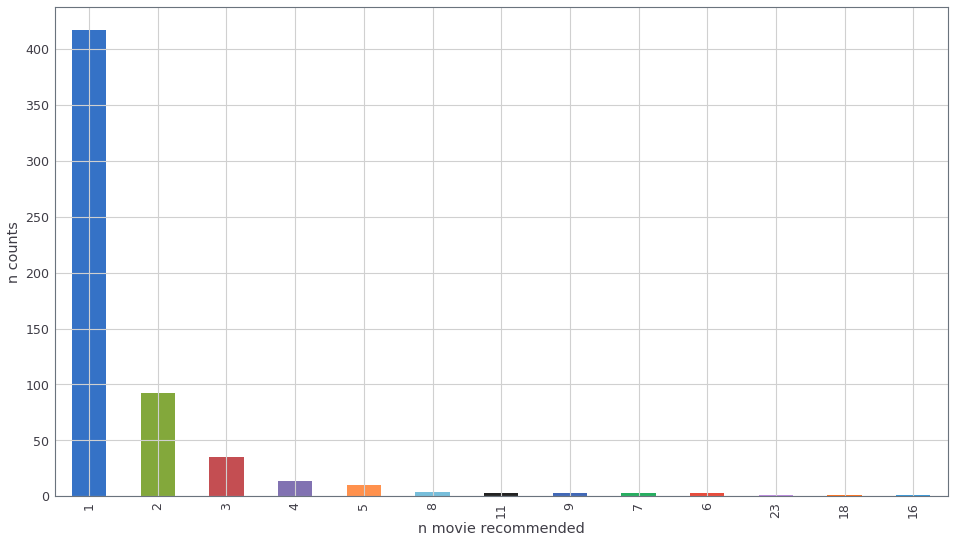

In [9]:
ax = pd.Series(counts).value_counts().plot(kind='bar', figsize=(16, 9))
ax.set_xlabel("n movie recommended")
ax.set_ylabel("n counts")

## InnerProduct

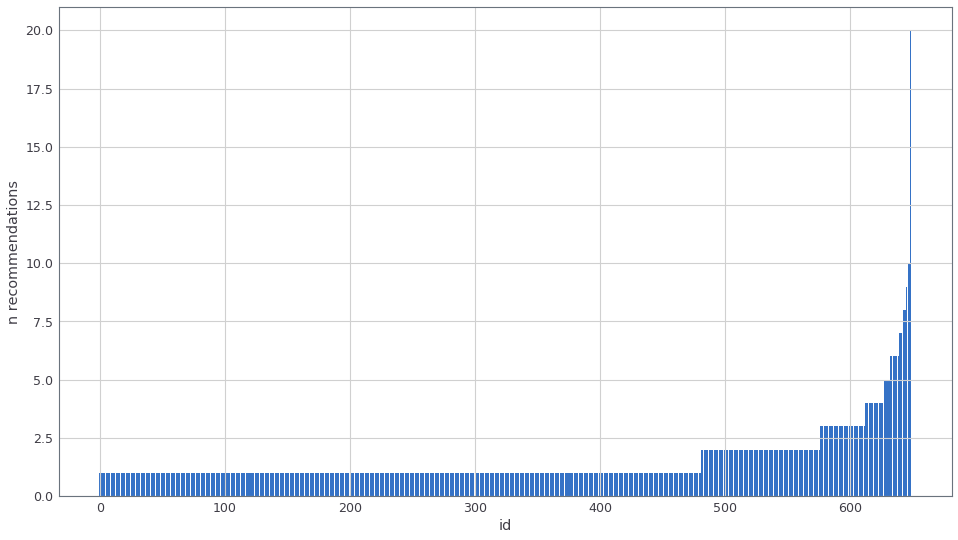

In [10]:
D, I = query(indexIP, ddpg_action)
uniques, counts = np.unique(I, return_counts=True)

ax = plt.figure(figsize=(16,9))
# p.s. expluding one
ax = plt.subplot()
ax.bar(range(len(counts)), sorted(counts))
ax.set_xlabel("id")
ax.set_ylabel("n recommendations")

ip_ddpg = counts

Text(0, 0.5, 'n counts')

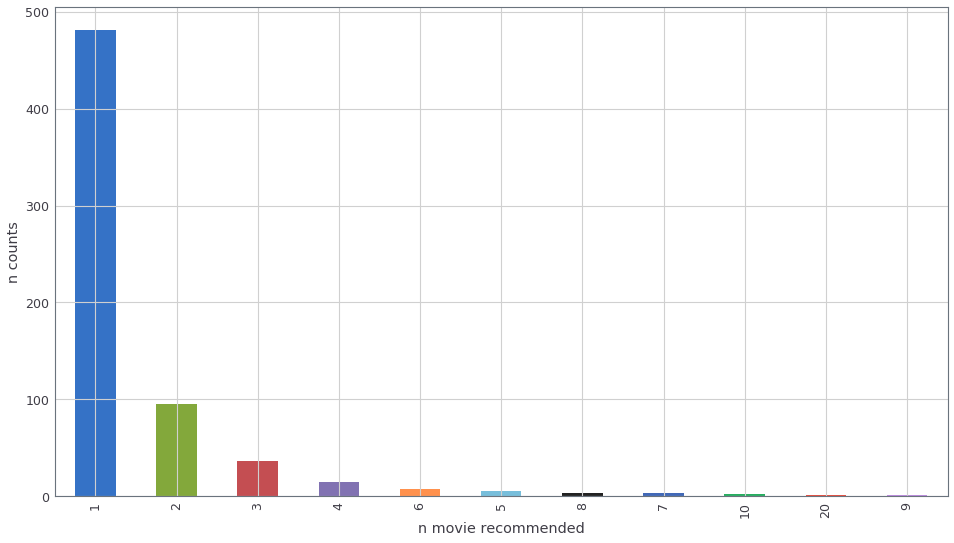

In [11]:
ax = pd.Series(counts).value_counts().plot(kind='bar', figsize=(16, 9))
ax.set_xlabel("n movie recommended")
ax.set_ylabel("n counts")

# TD3

In [12]:
td3_action = td3(state)
td3_action = td3_action[np.random.randint(0, 5000, 50)].detach().cpu().numpy() 

## L2

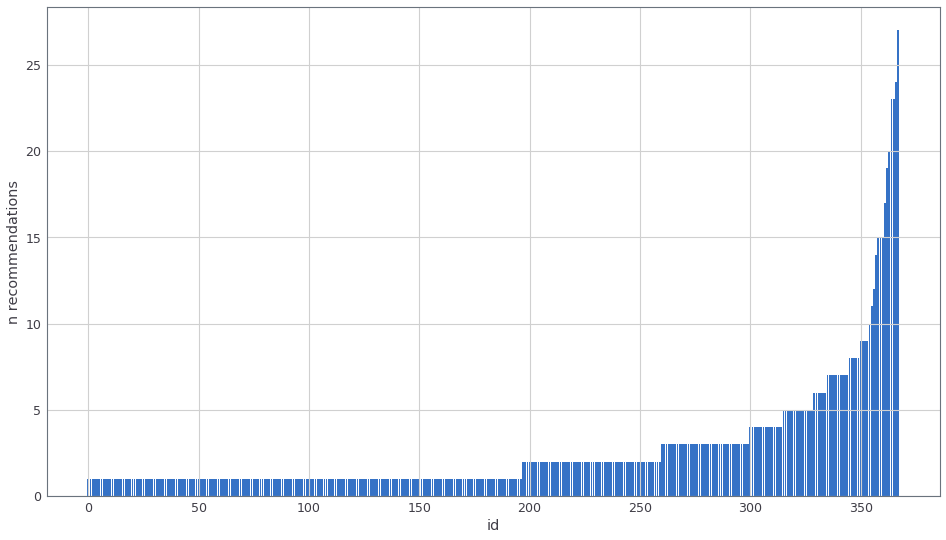

In [13]:
D, I = query(indexL2, td3_action)
uniques, counts = np.unique(I, return_counts=True)

ax = plt.figure(figsize=(16,9))
# p.s. expluding one
ax = plt.subplot()
ax.bar(range(len(counts)), sorted(counts))
ax.set_xlabel("id")
ax.set_ylabel("n recommendations")
l2_td3 = counts

Text(0, 0.5, 'n counts')

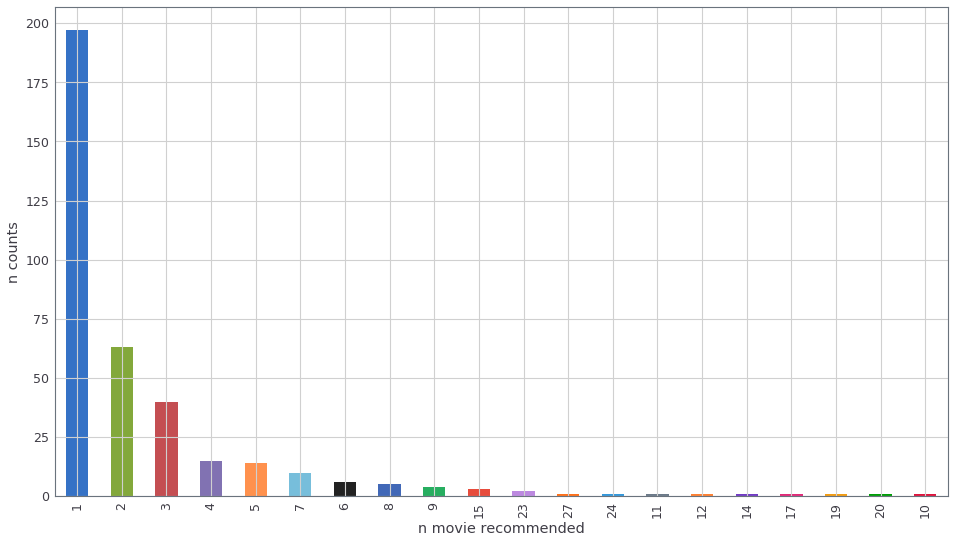

In [14]:
ax = pd.Series(counts).value_counts().plot(kind='bar', figsize=(16, 9))
ax.set_xlabel("n movie recommended")
ax.set_ylabel("n counts")

# InnerProduct

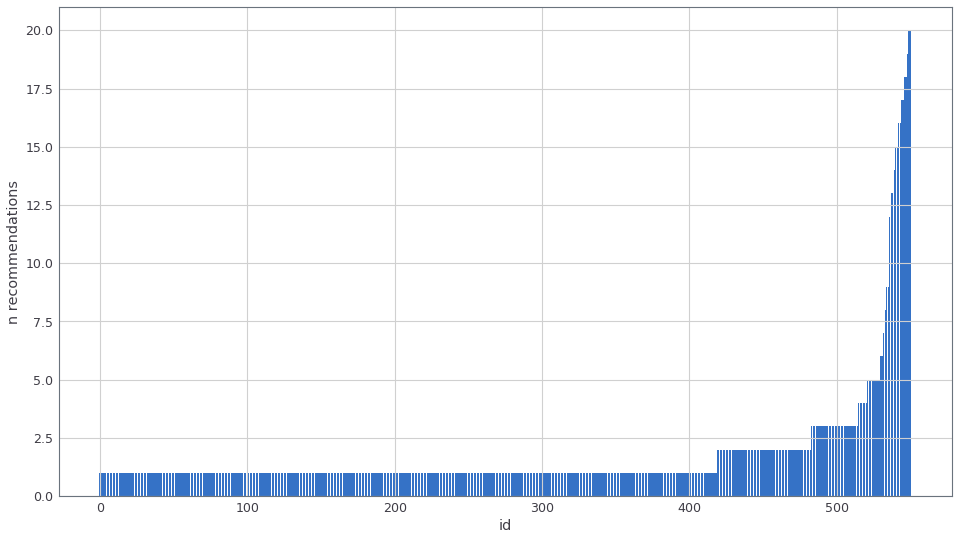

In [15]:
D, I = query(indexIP, td3_action)
uniques, counts = np.unique(I, return_counts=True)

ax = plt.figure(figsize=(16,9))
# p.s. expluding one
ax = plt.subplot()
ax.bar(range(len(counts)), sorted(counts))
ax.set_xlabel("id")
ax.set_ylabel("n recommendations")
ip_td3 = counts

Text(0, 0.5, 'n counts')

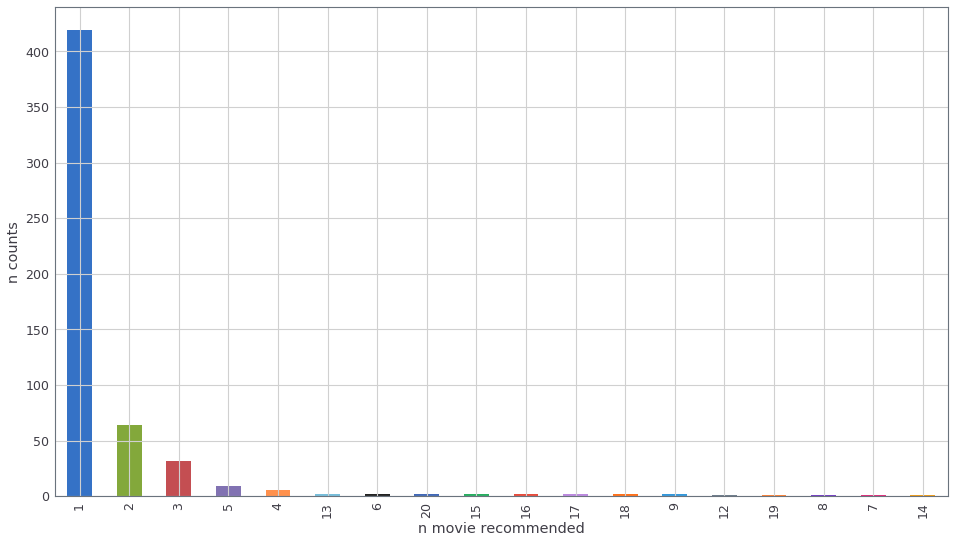

In [16]:
ax = pd.Series(counts).value_counts().plot(kind='bar', figsize=(16, 9))
ax.set_xlabel("n movie recommended")
ax.set_ylabel("n counts")

# BCQ

In [17]:
bcq_actor = models.BCQ_Actor(1290, 128, 256).to(cuda)
bcq_vae = models.BCQ_VAE(1290, 128, 512).to(cuda)

bcq_actor.load_state_dict(torch.load('../../models/BCQ/bcq_policy.pt'))
bcq_vae.load_state_dict(torch.load('../../models/BCQ/bcq_vae.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [18]:
sampled_actions = bcq_vae.decode(state)
perturbed_actions= bcq_actor(state, sampled_actions)
bcq_action = perturbed_actions[np.random.randint(0, 5000, 50)].detach().cpu().numpy() 

## L2

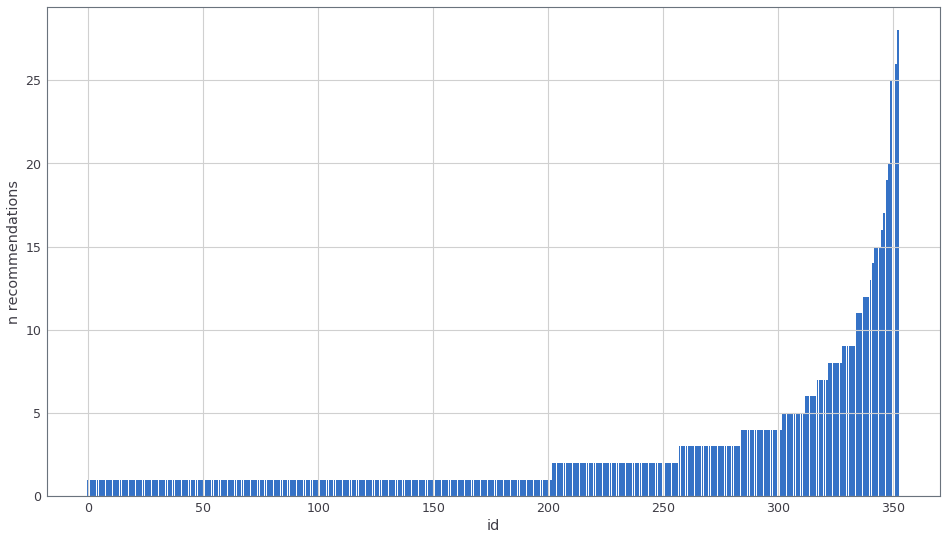

In [19]:
D, I = query(indexL2, bcq_action)
uniques, counts = np.unique(I, return_counts=True)

ax = plt.figure(figsize=(16,9))
# p.s. expluding one
ax = plt.subplot()
ax.bar(range(len(counts)), sorted(counts))
ax.set_xlabel("id")
ax.set_ylabel("n recommendations")
l2_bcq = counts

Text(0, 0.5, 'n counts')

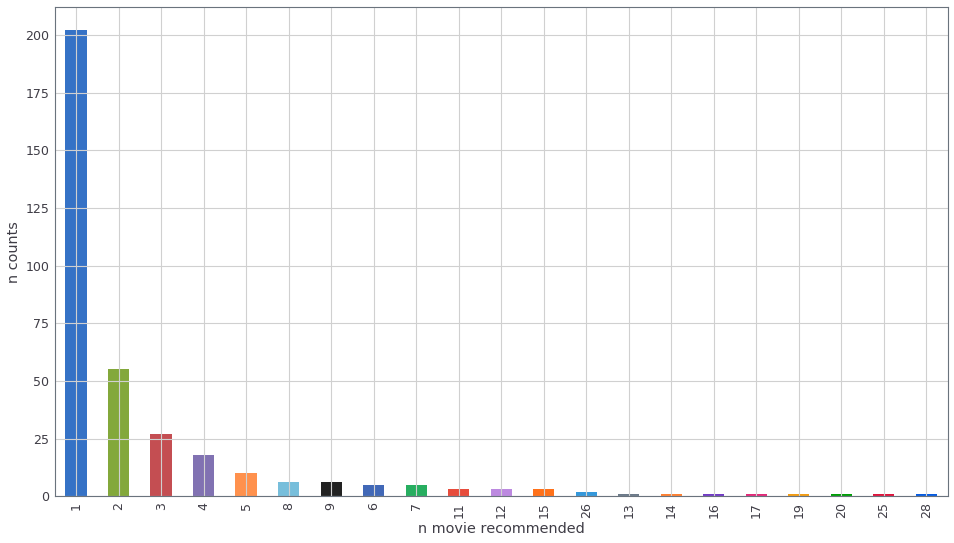

In [20]:
ax = pd.Series(counts).value_counts().plot(kind='bar', figsize=(16, 9))
ax.set_xlabel("n movie recommended")
ax.set_ylabel("n counts")

## InnerProduct

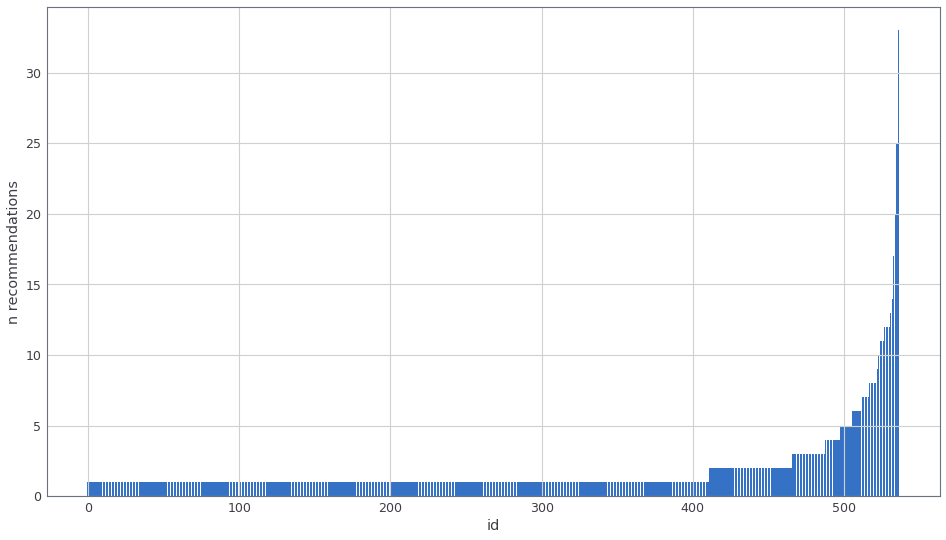

In [21]:
D, I = query(indexIP, bcq_action)
uniques, counts = np.unique(I, return_counts=True)

ax = plt.figure(figsize=(16,9))
# p.s. expluding one
ax = plt.subplot()
ax.bar(range(len(counts)), sorted(counts))
ax.set_xlabel("id")
ax.set_ylabel("n recommendations")
ip_bcq = counts

Text(0, 0.5, 'n counts')

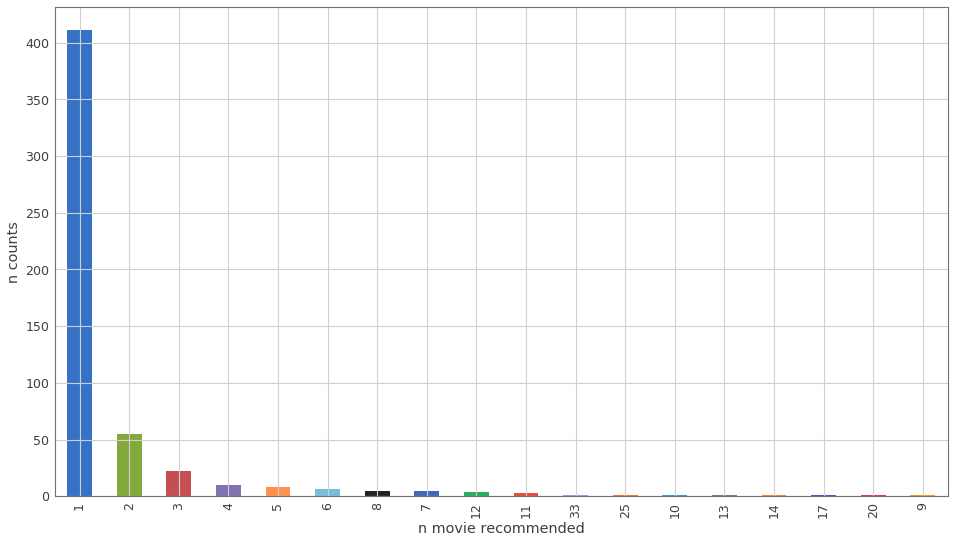

In [22]:
ax = pd.Series(counts).value_counts().plot(kind='bar', figsize=(16, 9))
ax.set_xlabel("n movie recommended")
ax.set_ylabel("n counts")

# Grouped comparison

## L2 top 30

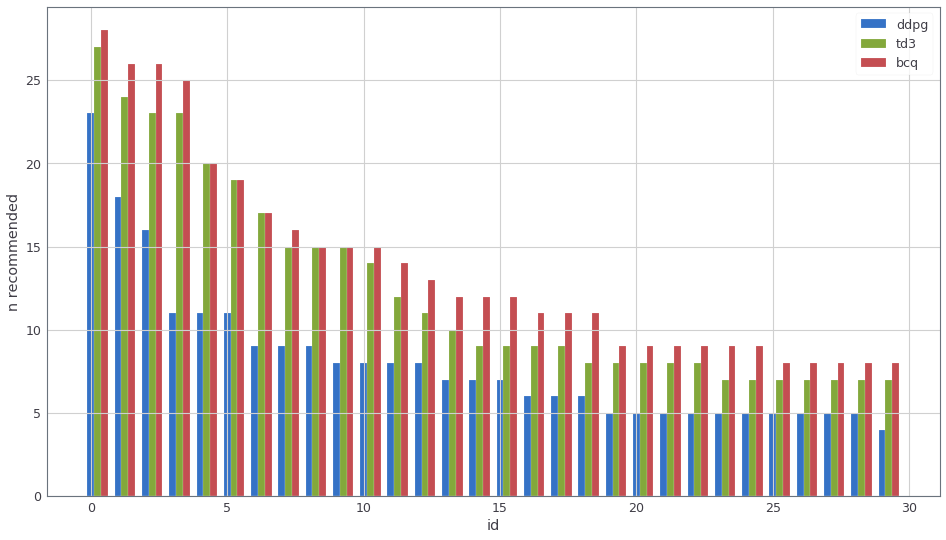

In [23]:
l2_ddpg_ = np.sort(l2_ddpg)[::-1][:30]
l2_td3_  = np.sort(l2_td3)[::-1][:30]
l2_bcq_  = np.sort(l2_bcq)[::-1][:30]

barWidth = 0.25
r1 = np.arange(len(l2_ddpg))[:30]
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.figure(figsize=(16, 9))

plt.bar(r1, l2_ddpg_, width=barWidth, edgecolor='white', label='ddpg')
plt.bar(r2, l2_td3_, width=barWidth, edgecolor='white', label='td3')
plt.bar(r3, l2_bcq_, width=barWidth, edgecolor='white', label='bcq')
 
# Add xticks on the middle of the group bars
plt.xlabel('id')
plt.ylabel('n recommended')
 
# Create legend & Show graphic
plt.legend()
plt.show()


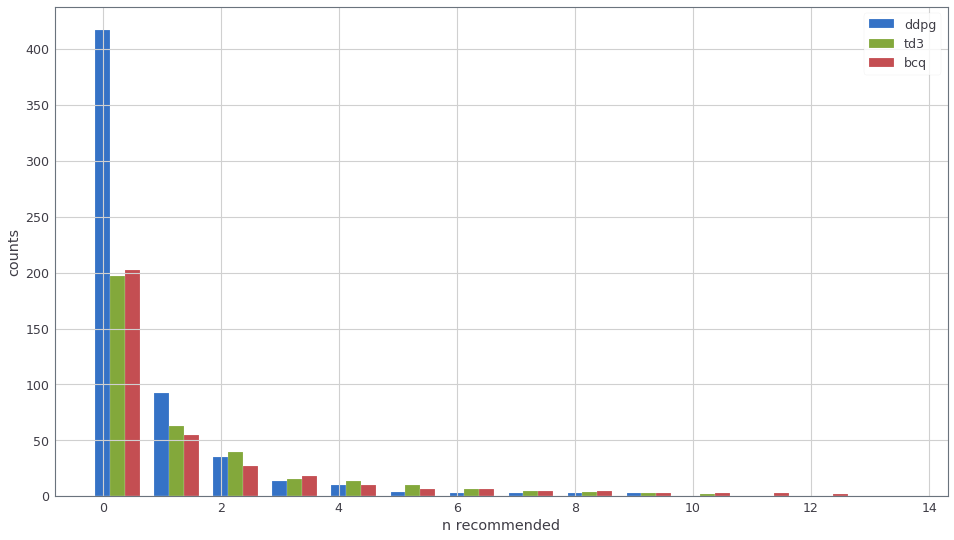

In [24]:
l2_ddpg_counts, l2_td3_counts, l2_bcq_counts = [pd.Series(i).value_counts() for i in [l2_ddpg, l2_td3, l2_bcq]]
l2_ddpg_counts, l2_td3_counts, l2_bcq_counts = [i[i > 1] for i in [l2_ddpg_counts, l2_td3_counts, l2_bcq_counts]]

unique_idx = l2_ddpg_counts.index.unique()| l2_td3_counts.index.unique() | l2_bcq_counts.index.unique()

for arr in [l2_ddpg_counts, l2_td3_counts, l2_bcq_counts]:
    for i in unique_idx:
        if i not in arr:
            arr[i] = 0

barWidth = 0.25
r1 = np.arange(len(l2_ddpg_counts))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.figure(figsize=(16, 9))

plt.bar(r1, l2_ddpg_counts, width=barWidth, edgecolor='white', label='ddpg')
plt.bar(r2, l2_td3_counts, width=barWidth, edgecolor='white', label='td3')
plt.bar(r3, l2_bcq_counts, width=barWidth, edgecolor='white', label='bcq')
 
# Add xticks on the middle of the group bars
plt.xlabel('n recommended')
plt.ylabel('counts')
 
# Create legend & Show graphic
plt.legend()
plt.show()

## InnerProduct top 30

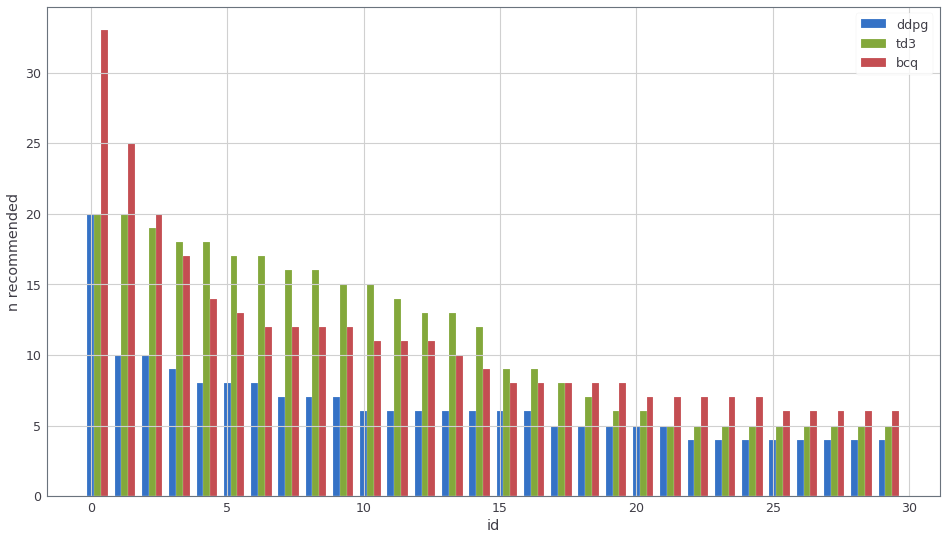

In [29]:
ip_ddpg_ = np.sort(ip_ddpg)[::-1][:30]
ip_td3_  = np.sort(ip_td3)[::-1][:30]
ip_bcq_  = np.sort(ip_bcq)[::-1][:30]

barWidth = 0.25
r1 = np.arange(len(ip_ddpg))[:30]
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.figure(figsize=(16, 9))

plt.bar(r1, ip_ddpg_, width=barWidth, edgecolor='white', label='ddpg')
plt.bar(r2, ip_td3_, width=barWidth, edgecolor='white', label='td3')
plt.bar(r3, ip_bcq_, width=barWidth, edgecolor='white', label='bcq')
 
# Add xticks on the middle of the group bars
plt.xlabel('id')
plt.ylabel('n recommended')
 
# Create legend & Show graphic
plt.legend()
plt.show()

## InnerProduct top 30-50

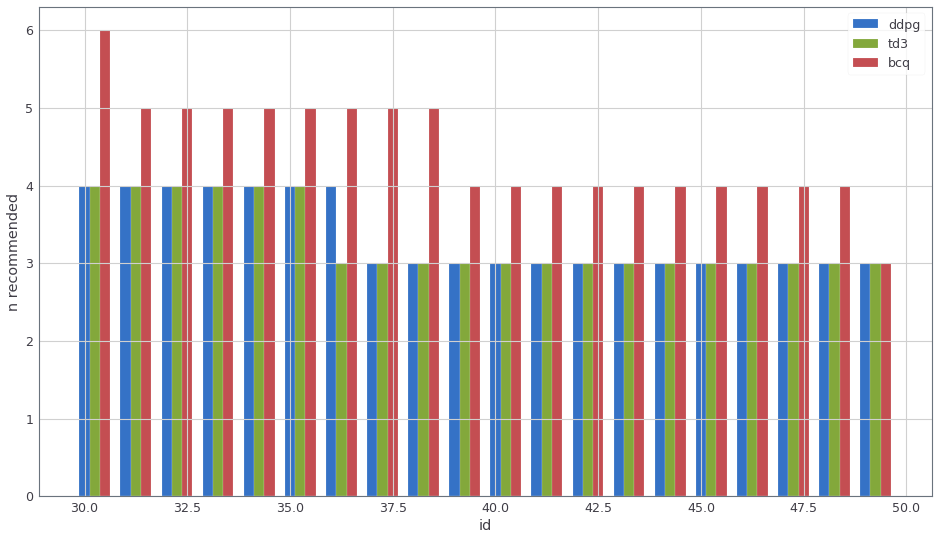

In [30]:
ip_ddpg_ = np.sort(ip_ddpg)[::-1][30:50]
ip_td3_  = np.sort(ip_td3)[::-1][30:50]
ip_bcq_  = np.sort(ip_bcq)[::-1][30:50]

barWidth = 0.25
r1 = np.arange(len(ip_ddpg))[30:50]
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.figure(figsize=(16, 9))

plt.bar(r1, ip_ddpg_, width=barWidth, edgecolor='white', label='ddpg')
plt.bar(r2, ip_td3_, width=barWidth, edgecolor='white', label='td3')
plt.bar(r3, ip_bcq_, width=barWidth, edgecolor='white', label='bcq')
 
# Add xticks on the middle of the group bars
plt.xlabel('id')
plt.ylabel('n recommended')
 
# Create legend & Show graphic
plt.legend()
plt.show()

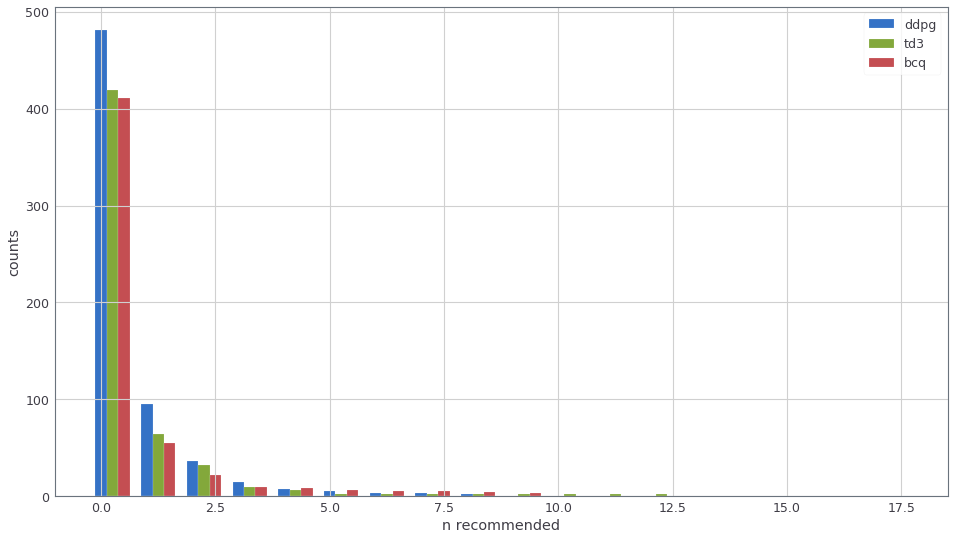

In [31]:
ip_ddpg_counts, ip_td3_counts, ip_bcq_counts = [pd.Series(i).value_counts() for i in [ip_ddpg, ip_td3, ip_bcq]]
ip_ddpg_counts, ip_td3_counts, ip_bcq_counts = [i[i > 1] for i in [ip_ddpg_counts, ip_td3_counts, ip_bcq_counts]]

unique_idx = ip_ddpg_counts.index.unique()| ip_td3_counts.index.unique() | ip_bcq_counts.index.unique()

for arr in [ip_ddpg_counts, ip_td3_counts, ip_bcq_counts]:
    for i in unique_idx:
        if i not in arr:
            arr[i] = 0

barWidth = 0.25
r1 = np.arange(len(ip_ddpg_counts))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.figure(figsize=(16, 9))

plt.bar(r1, ip_ddpg_counts, width=barWidth, edgecolor='white', label='ddpg')
plt.bar(r2, ip_td3_counts, width=barWidth, edgecolor='white', label='td3')
plt.bar(r3, ip_bcq_counts, width=barWidth, edgecolor='white', label='bcq')
 
# Add xticks on the middle of the group bars
plt.xlabel('n recommended')
plt.ylabel('counts')
 
# Create legend & Show graphic
plt.legend()
plt.show()